#  Movie Embeddings

### Importing Packages

In [1]:
#importing packages
import re
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import warnings
warnings.filterwarnings("ignore")

## Q2 - 1 -Computing Target (Xij) dataset from movielens

### Loading Datasets

In [2]:
#Loading Datasets

ratings_ds = pd.read_csv('ml-latest-small/ratings.csv')
movies_ds = pd.read_csv('ml-latest-small/movies.csv')
tags_ds = pd.read_csv('ml-latest-small/tags.csv')
links_ds=  pd.read_csv('ml-latest-small/links.csv')

In [3]:
#adding column to ratings table to check whether user likes a movie or not

ratings_ds['Like']=np.where(ratings_ds['rating']>=4,1,0)

In [4]:
ratings_ds2 = ratings_ds.drop(['rating'],axis=1) #Dropping rating column

In [5]:
# creating a pivot using userId and movieId of ratings table

ratings_ds2_pivot = ratings_ds2.pivot(index = 'userId', columns ='movieId', values = 'Like').fillna(0)

In [6]:
ratings_ds2_pivot.shape#matrix created

(610, 9724)

In [7]:
#creating a co-occurence matrix , Each entry Xi,j is the number of users who like both movie i and j
rating_co_occ = ratings_ds2_pivot.T.dot(ratings_ds2_pivot)

In [8]:
rating_co_occ.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,147.0,21.0,11.0,0.0,7.0,27.0,7.0,1.0,4.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.0,50.0,5.0,0.0,4.0,8.0,6.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.0,5.0,18.0,0.0,4.0,4.0,5.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7.0,4.0,4.0,0.0,12.0,3.0,4.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
rating_co_occ.shape

(9724, 9724)

##  Creating and optimising the loss function

In [10]:
# converting rating_co_occ to matrix with diagonal elements as 0 to help in loss function

observed=rating_co_occ.as_matrix()
np.fill_diagonal(observed, 0)

In [11]:
# converting matrix to tensor using torch

observed = torch.from_numpy(rating_co_occ.as_matrix()).float()
observed

tensor([[ 0., 21., 11.,  ...,  0.,  0.,  0.],
        [21.,  0.,  5.,  ...,  0.,  0.,  0.],
        [11.,  5.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [12]:
# creating a reference table with movieId, indexes of movies, movie name and genre

reference = rating_co_occ.reset_index()
reference = reference.merge(movies_ds, on='movieId', how='inner')

In [13]:
reference["movie"]=reference["title"].str.split('(',expand=True)[0].str.strip().str.lower()

In [14]:
reference.head(3)

,movieId,1,2,3,4,5,6,7,8,9,...,193573,193579,193581,193583,193585,193587,193609,title,genres,movie
0,1,0.0,21.0,11.0,0.0,7.0,27.0,7.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,toy story
1,2,21.0,0.0,5.0,0.0,4.0,8.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jumanji (1995),Adventure|Children|Fantasy,jumanji
2,3,11.0,5.0,0.0,0.0,4.0,4.0,5.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Grumpier Old Men (1995),Comedy|Romance,grumpier old men


In [15]:
# creating a One Hot Encoder matrix

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
data = reference["movieId"].unique()
values = array(data)
print(values)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

[     1      2      3 ... 193585 193587 193609]
[   0    1    2 ... 9721 9722 9723]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[1]


In [16]:
#taking input OHE to NN module

movies_tensor = torch.from_numpy(onehot_encoded).float()
movies_tensor= torch.tensor(movies_tensor)
#movies_tensor.requires_grad

In [17]:
# Creating a model to calulculate loss function and optimise using gradient descent

import torch
torch.nn.Linear

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in,H, D_out = 9724, 300, 9724
loss_array =[]
# Create random Tensors to hold inputs and outputs
x = movies_tensor
y = observed

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    # Forward pass: compute predicted y by passing x to the model.
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()





0 63482988.0
20 22604410.0
40 8410871.0
60 5171159.0
80 3722297.0
100 2772058.0
120 2110179.75
140 1642771.875
160 1306905.875
180 1058600.125
200 871652.125


#### Loss of cost function after 200 iterations is:

In [18]:
# plot of loss vs interations
import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

<Figure size 640x480 with 1 Axes>

## Recommending top 10 movies

In [19]:
# Creating a prediction function to give movie recommendations

def prediction(moviename):
    
    #getting tensor for movie
    moviename= moviename.lower()
    idx = reference[reference["movie"]== moviename].index[0]   
    movie = movies_tensor[idx]
    movie = movie.reshape(1,movie.shape[0])
    
    #storing weight vector from model
    for name, param in model.named_parameters():
        weight_vector = param
    
    # prediction for given movie
    movie_i = model(movie)
    pred = torch.mm(movie_i,weight_vector)
    
    # movie index value sorted from min to max for predicted score values
    
    pred_idx = (-np.asanyarray(pred[0].detach().numpy())).argsort()[:10]
    
    # Getting title of recommended movie from Reference Dataframe
    recommendations = reference["title"].iloc[pred_idx]
    
    return recommendations
    

In [20]:
# Creating a function to see top 10 movies recommendation for a movie in Xij matrix

def observed_reco(moviename):
    
    # Getting Index of Movie from MovieId
    idx = reference[reference["movie"]== moviename].index[0]
    
    # Sorting top 10 movie indexes from Co-Occurence Matrix
    obs_idx = (-np.asanyarray(rating_co_occ.iloc[idx])).argsort()[:10]
    
    # Getting movie title from top 10 movie indexes
    recommendations = reference["title"].iloc[obs_idx]
    
    return recommendations

#### Top 10 movie prediction for Apollo 13

In [23]:
display("Model Predictions:",prediction("APOLLO 13"),"Actual Predictions:", observed_reco("apollo 13"))

'Model Predictions:'

314                          Forrest Gump (1994)
277             Shawshank Redemption, The (1994)
257                          Pulp Fiction (1994)
510             Silence of the Lambs, The (1991)
123                             Apollo 13 (1995)
97                             Braveheart (1995)
418                         Jurassic Park (1993)
398                         Fugitive, The (1993)
461                      Schindler's List (1993)
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object

'Actual Predictions:'

277             Shawshank Redemption, The (1994)
314                          Forrest Gump (1994)
257                          Pulp Fiction (1994)
418                         Jurassic Park (1993)
510             Silence of the Lambs, The (1991)
398                         Fugitive, The (1993)
97                             Braveheart (1995)
461                      Schindler's List (1993)
507            Terminator 2: Judgment Day (1991)
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object

#### Top 10 movie recommendations for Toy Story

In [24]:
display("Model Predictions:",prediction("toy story"),"Actual Predictions:", observed_reco("toy story"))

'Model Predictions:'

277                      Shawshank Redemption, The (1994)
314                                   Forrest Gump (1994)
257                                   Pulp Fiction (1994)
510                      Silence of the Lambs, The (1991)
224             Star Wars: Episode IV - A New Hope (1977)
1938                                   Matrix, The (1999)
897     Star Wars: Episode V - The Empire Strikes Back...
899     Raiders of the Lost Ark (Indiana Jones and the...
0                                        Toy Story (1995)
418                                  Jurassic Park (1993)
Name: title, dtype: object

'Actual Predictions:'

277                      Shawshank Redemption, The (1994)
314                                   Forrest Gump (1994)
224             Star Wars: Episode IV - A New Hope (1977)
257                                   Pulp Fiction (1994)
510                      Silence of the Lambs, The (1991)
897     Star Wars: Episode V - The Empire Strikes Back...
1938                                   Matrix, The (1999)
418                                  Jurassic Park (1993)
899     Raiders of the Lost Ark (Indiana Jones and the...
910     Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object

#### Top 10 movie predictions for Home Alone

In [25]:
display("Model Predictions:",prediction("home alone"),"Actual Predictions:", observed_reco("home alone"))

'Model Predictions:'

314                           Forrest Gump (1994)
504                             Home Alone (1990)
418                          Jurassic Park (1993)
277              Shawshank Redemption, The (1994)
506                                Aladdin (1992)
322                         Lion King, The (1994)
1938                           Matrix, The (1999)
224     Star Wars: Episode IV - A New Hope (1977)
0                                Toy Story (1995)
510              Silence of the Lambs, The (1991)
Name: title, dtype: object

'Actual Predictions:'

314                   Forrest Gump (1994)
418                  Jurassic Park (1993)
277      Shawshank Redemption, The (1994)
506                        Aladdin (1992)
322                 Lion King, The (1994)
507     Terminator 2: Judgment Day (1991)
0                        Toy Story (1995)
510      Silence of the Lambs, The (1991)
1938                   Matrix, The (1999)
257                   Pulp Fiction (1994)
Name: title, dtype: object

### Changing Learning Rates:

#### Increasing the learning rate by 100 times to 1

In [26]:
# Changing learning rate to 1

import torch
torch.nn.Linear

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in,H, D_out = 9724, 300, 9724
loss_array =[]
# Create random Tensors to hold inputs and outputs
x = movies_tensor
y = observed

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    # Forward pass: compute predicted y by passing x to the model.
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()




0 63482960.0
20 8544730112.0
40 797102976.0
60 76067680.0
80 17497732.0
100 10002587.0
120 7385810.0
140 5871215.0
160 4855597.0
180 4121301.75
200 3560509.25


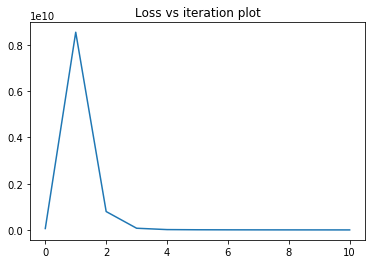

In [27]:
# plot of loss vs interations
import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

#### The predictions for Apollo 13 show that these are similar to the actual predictions but still the recommedations are a little different from the actual predictions and from what we got when the learning rate was 0.01

In [58]:
prediction("apollo 13")

4607                             Kill Bill: Vol. 1 (2003)
827                                 Reservoir Dogs (1992)
123                                      Apollo 13 (1995)
224             Star Wars: Episode IV - A New Hope (1977)
314                                   Forrest Gump (1994)
3814                                    Spider-Man (2002)
3633    Lord of the Rings: The Fellowship of the Ring,...
4131        Lord of the Rings: The Two Towers, The (2002)
2729                               Blazing Saddles (1974)
1260                             Starship Troopers (1997)
Name: title, dtype: object

#### Lowering the learning rate by 100 times to 0.0001

In [55]:
# Lowering the learning rate by 100 times to 0.0001

import torch
torch.nn.Linear

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in,H, D_out = 9724, 300, 9724
loss_array =[]
# Create random Tensors to hold inputs and outputs
x = movies_tensor
y = observed

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    # Forward pass: compute predicted y by passing x to the model.
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()




0 63482976.0
20 63456452.0
40 63351876.0
60 63136012.0
80 62801520.0
100 62358824.0
120 61824716.0
140 61216272.0
160 60548940.0
180 59835288.0
200 59085028.0


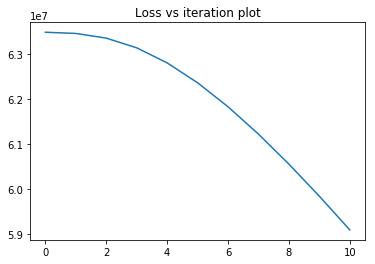

In [57]:
# plot of loss vs interations
import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

#### The predictions for Apollo 13 will show that these are much different than the actual predictions and also from the one we have recommended when the learning rate is 0.01

In [56]:
prediction("apollo 13")

4607                             Kill Bill: Vol. 1 (2003)
827                                 Reservoir Dogs (1992)
123                                      Apollo 13 (1995)
224             Star Wars: Episode IV - A New Hope (1977)
314                                   Forrest Gump (1994)
3814                                    Spider-Man (2002)
3633    Lord of the Rings: The Fellowship of the Ring,...
4131        Lord of the Rings: The Two Towers, The (2002)
2729                               Blazing Saddles (1974)
1260                             Starship Troopers (1997)
Name: title, dtype: object

### Our Analysis

#### Learning rate scales the magnitude of our weights in order to minimize the network's loss function. If learning rate is set to a high value it would keep bouncing as it nears the optimal point and my not reach the optimal point and thus give us incorrect recommendations. Whereas, if learning rate is too small, then training will progress very slowly as we are making very tiny updates to the weight and there is a chance to get stuck in local minima and our gradient descent function will give constant loss with increase in iterations, resulting in high cost and incorrect recommendations.